In [18]:
from __future__ import print_function

import os

import numpy as np
from keras.layers import RepeatVector
from keras.layers.core import Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.models import load_model

import matplotlib.pylab as plt

np.random.seed(123)

In [3]:
def prepare_sequences(x_train, window_length, random_indices):
    full_sequence = x_train.flatten()
    windows = []
    outliers = []
    for window_start in range(0, len(full_sequence) - window_length + 1):
        window_end = window_start + window_length
        window_range = range(window_start, window_end)
        window = list(full_sequence[window_range])
        contain_outlier = len(set(window_range).intersection(set(random_indices))) > 0
        outliers.append(contain_outlier)
        windows.append(window)
    return np.expand_dims(np.array(windows), axis=2), outliers


def get_signal(size, outliers_size=0.01):
    sig = np.expand_dims(np.random.normal(loc=0, scale=1, size=(size, 1)), axis=1)
    if outliers_size < 1:  # percentage.
        outliers_size = int(size * outliers_size)
    random_indices = np.random.choice(range(size), size=outliers_size, replace=False)
    sig[random_indices] = np.random.randint(6, 9, 1)[0]
    return sig, random_indices


def tp_fn_fp_tn(total, expected, actual):
    tp = len(set(expected).intersection(set(actual)))
    fn = len(set(expected) - set(actual))
    fp = len(set(actual) - set(expected))
    tn = len((total - set(expected)).intersection(total - set(actual)))
    return tp, fn, fp, tn

In [4]:
window_length = 10
# select_only_last_state = False
# model_file = 'model.h5'
hidden_dim = 16

# no outliers.
signal_train, _ = get_signal(100000, outliers_size=0)
x_train, _ = prepare_sequences(signal_train, window_length, [])

# 1 percent are outliers.
signal_test, random_indices = get_signal(100000, outliers_size=0.01)
x_test, contain_outliers = prepare_sequences(signal_test, window_length, random_indices)
outlier_indices = np.where(contain_outliers)[0]





In [5]:
x_train.shape, x_test.shape, outlier_indices.shape

((99991, 10, 1), (99991, 10, 1), (9465,))

In [6]:

m = Sequential()
#     if select_only_last_state:
#         m.add(LSTM(hidden_dim, input_shape=(window_length, 1), return_sequences=False))
#         m.add(RepeatVector(window_length))
#     else:
m.add(LSTM(hidden_dim, input_shape=(window_length, 1), return_sequences=True))
m.add(Dropout(p=0.1))
m.add(LSTM(1, return_sequences=True, activation='linear'))
m.compile(loss='mse', optimizer='adam')
m.fit(x_train, x_train, batch_size=64, nb_epoch=5, validation_data=(x_test, x_test))
# m.save(model_file)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 99991 samples, validate on 99991 samples
Epoch 1/5
99991/99991 [==============================] - 44s - loss: 0.1157 - val_loss: 0.2177
Epoch 2/5
99991/99991 [==============================] - 43s - loss: 0.0154 - val_loss: 0.1921
Epoch 3/5
99991/99991 [==============================] - 44s - loss: 0.0116 - val_loss: 0.1648
Epoch 4/5
99991/99991 [==============================] - 42s - loss: 0.0098 - val_loss: 0.1349
Epoch 5/5
99991/99991 [==============================] - 42s - loss: 0.0088 - val_loss: 0.1135


In [7]:
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 16)            1152      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 16)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 1)             72        
Total params: 1,224
Trainable params: 1,224
Non-trainable params: 0
_________________________________________________________________


In [8]:
pred_x_test = m.predict(x_test)
mae_of_predictions = np.squeeze(np.max(np.square(pred_x_test - x_test), axis=1))
mae_threshold = np.mean(mae_of_predictions) + np.std(mae_of_predictions)  # can use a running mean instead.
actual = np.where(mae_of_predictions > mae_threshold)[0]

tp, fn, fp, tn = tp_fn_fp_tn(set(range(len(pred_x_test))), outlier_indices, actual)
precision = float(tp) / (tp + fp)
hit_rate = float(tp) / (tp + fn)
accuracy = float(tp + tn) / (tp + tn + fp + fn)

print('precision = {}, hit_rate = {}, accuracy = {}'.format(precision, hit_rate, accuracy))

precision = 1.0, hit_rate = 1.0, accuracy = 1.0


In [34]:
#change max to sum
pred_x_test = m.predict(x_test)
mae_of_predictions = np.squeeze(np.sum(np.square(pred_x_test - x_test), axis=1))
mae_threshold = np.mean(mae_of_predictions) + np.std(mae_of_predictions)  # can use a running mean instead.
actual = np.where(mae_of_predictions > mae_threshold)[0]

tp, fn, fp, tn = tp_fn_fp_tn(set(range(len(pred_x_test))), outlier_indices, actual)
precision = float(tp) / (tp + fp)
hit_rate = float(tp) / (tp + fn)
accuracy = float(tp + tn) / (tp + tn + fp + fn)

print('precision = {}, hit_rate = {}, accuracy = {}'.format(precision, hit_rate, accuracy))

precision = 1.0, hit_rate = 1.0, accuracy = 1.0


In [36]:
np.sum(np.square(pred_x_test - x_test), axis=1).shape, actual.shape

((99991, 1), (9465,))

In [25]:
np.square(pred_x_test - x_test).shape, np.max(np.square(pred_x_test - x_test), axis=1).shape

((99991, 10, 1), (99991, 1))

In [31]:
np.square(pred_x_test - x_test)[0:2]

array([[[  7.48934149e-05],
        [  1.02387648e-05],
        [  3.96011704e-05],
        [  4.10149342e-05],
        [  7.41022601e-05],
        [  3.69269517e-06],
        [  7.12892036e-08],
        [  6.92314781e-06],
        [  4.50619660e-06],
        [  3.08689933e-05]],

       [[  9.97674025e-06],
        [  1.10271715e-04],
        [  3.37550865e-05],
        [  8.66815086e-05],
        [  5.47310691e-06],
        [  3.16915089e-09],
        [  8.72373230e-06],
        [  4.54779320e-06],
        [  3.08537617e-05],
        [  7.00007682e-05]]])

In [41]:
 np.sum(np.sum(np.square(pred_x_test - x_test), axis=1))/len(x_test)/10

0.11351962416834874

In [37]:
 np.sum(np.square(pred_x_test - x_test), axis=1)[0:2], mae_of_predictions

(array([[ 0.00028591],
        [ 0.00036029]]),
 array([ 0.00028591,  0.00036029,  0.00049946, ...,  0.00049778,
         0.00064912,  0.00047846]))

In [33]:
 np.max(np.square(pred_x_test - x_test), axis=1)[0:2], mae_of_predictions

(array([[  7.48934149e-05],
        [  1.10271715e-04]]),
 array([  7.48934149e-05,   1.10271715e-04,   1.90947981e-04, ...,
          1.40363166e-04,   1.72828970e-04,   1.39958119e-04]))

In [24]:
pred_x_test.shape, mae_of_predictions.shape, actual.shape

((99991, 10, 1), (99991,), (9465,))

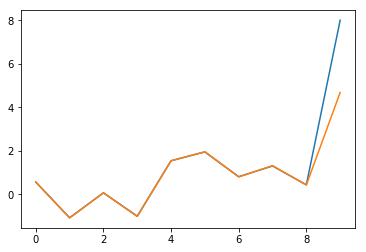

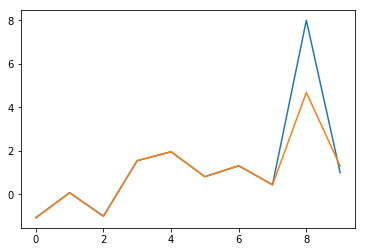

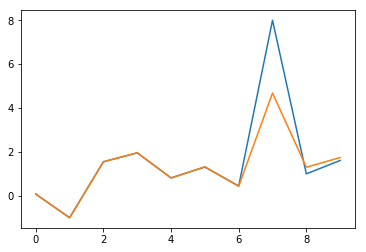

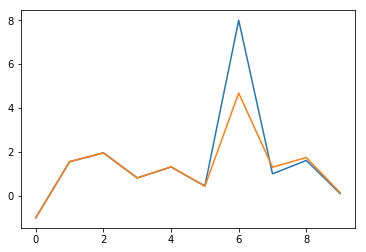

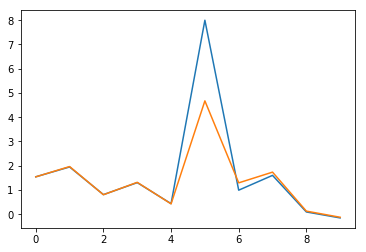

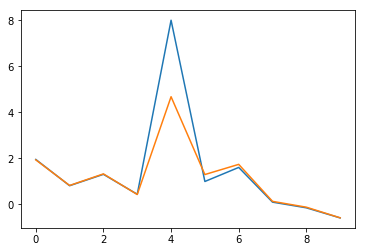

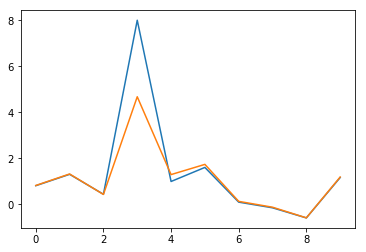

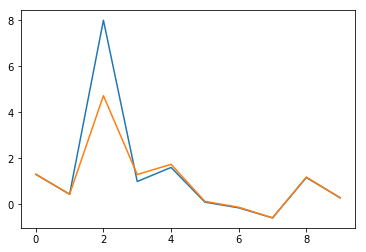

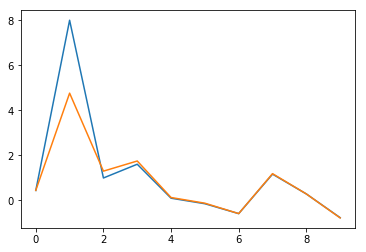

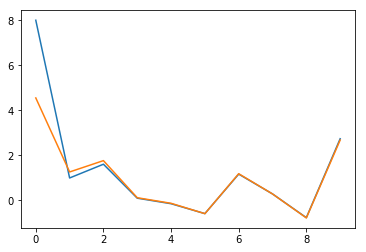

In [45]:
for index in outlier_indices[0:10]:
    plt.plot(x_test[index])
    plt.plot(pred_x_test[index])
    plt.show()

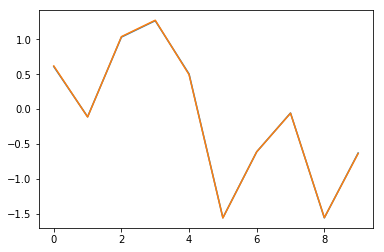

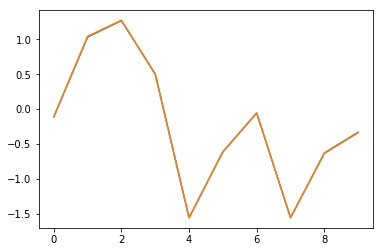

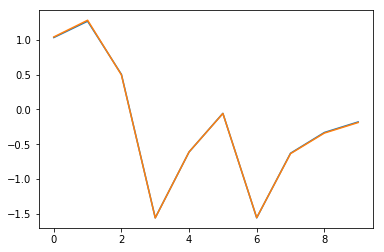

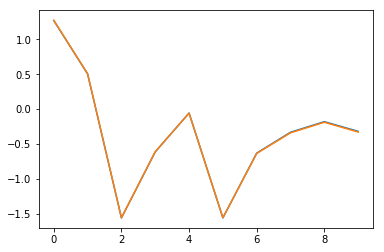

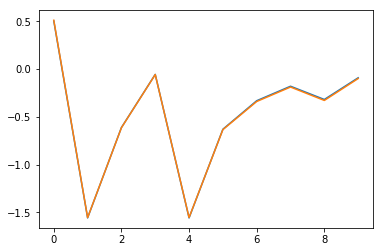

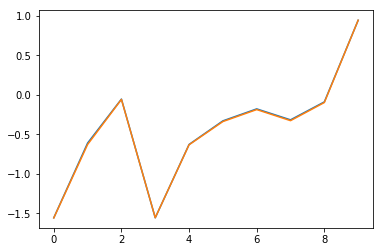

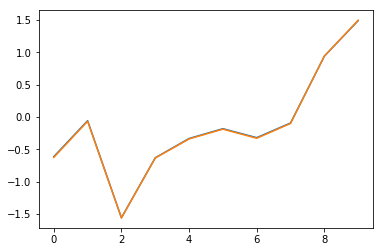

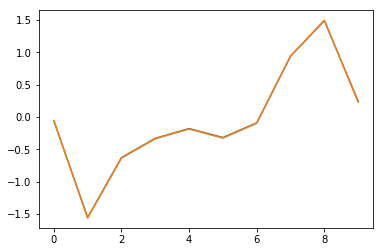

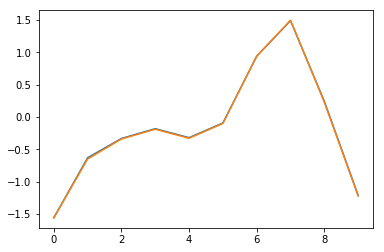

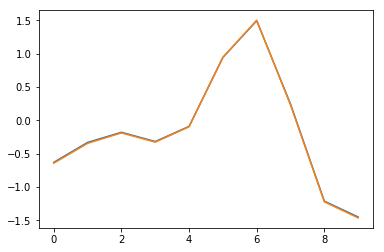

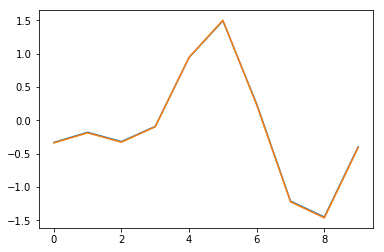

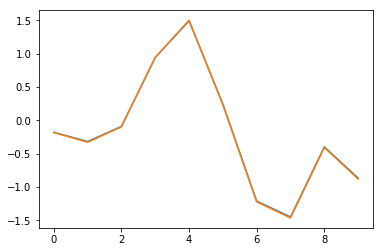

In [ ]:
for index in range(0,20):
    if index not in outlier_indices:
        plt.plot(x_test[index])
        plt.plot(pred_x_test[index])
        plt.show()


In [12]:
m.get_config()

[{'class_name': 'LSTM',
  'config': {'activation': 'tanh',
   'activity_regularizer': None,
   'batch_input_shape': (None, 10, 1),
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'dropout': 0.0,
   'dtype': 'float32',
   'go_backwards': False,
   'implementation': 0,
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'distribution': 'uniform',
     'mode': 'fan_avg',
     'scale': 1.0,
     'seed': None}},
   'kernel_regularizer': None,
   'name': 'lstm_1',
   'recurrent_activation': 'hard_sigmoid',
   'recurrent_constraint': None,
   'recurrent_dropout': 0.0,
   'recurrent_initializer': {'class_name': 'Orthogonal',
    'config': {'gain': 1.0, 'seed': None}},
   'recurrent_regularizer': None,
   'return_sequences': True,
   'return_state': False,
   'stateful': False,
   'trainable': True,
   'unit_forget_bias': True,
   'units': 16,
   'unroll': False,
   'use

In [17]:
all_weights = m.get_weights()
for item in all_weights:
    print (item.shape)

(1, 64)
(16, 64)
(64,)
(16, 4)
(1, 4)
(4,)
